In [1]:
# crypto_backtest.ipynb – setup

import os
from pathlib import Path

import numpy as np
import pandas as pd

# Notebook CWD is PREDICTION-MARKET-MONEY-PRINTER/notebooks
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
TRADES_DIR = BASE_DIR / "kalshi_fetcher" / "data" / "enriched_trades"

print("CWD:      ", os.getcwd())
print("BASE_DIR: ", BASE_DIR)
print("DATA_DIR: ", DATA_DIR)
print("TRADES_DIR:", TRADES_DIR)


CWD:       c:\Users\Adam Nhan\prediction-market-money-printer\notebooks
BASE_DIR:  C:\Users\Adam Nhan\prediction-market-money-printer
DATA_DIR:  C:\Users\Adam Nhan\prediction-market-money-printer\data
TRADES_DIR: C:\Users\Adam Nhan\prediction-market-money-printer\kalshi_fetcher\data\enriched_trades


In [2]:
# Step 2: Load enriched markets and filter to Crypto only

enriched_path = DATA_DIR / "enriched_markets.csv"
enriched_df = pd.read_csv(enriched_path)

# Keep only markets categorized as Crypto
crypto_df = enriched_df[enriched_df["category"] == "Crypto"].copy()

print("Total markets:", len(enriched_df))
print("Crypto markets:", len(crypto_df))
crypto_df.head(3)


Total markets: 800
Crypto markets: 400


,ticker,event_ticker,category,normalized_status,status,close_time,volume,last_price,result,settlement_value,title,category_event,series_ticker,event_time
400,KXETHD-25NOV0913-T4139.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z
401,KXETHD-25NOV0913-T4119.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z
402,KXETHD-25NOV0913-T4099.99,KXETHD-25NOV0913,Crypto,settled,finalized,2025-11-09T18:00:00Z,0,0,no,0,"Ethereum price on Nov 9, 2025 at 1pm EST?",Crypto,KXETHD,2025-11-09T18:00:00Z


In [3]:
# Step 3 (fixed): load combined_v4 with all engineered features

combined_v4_path = DATA_DIR / "combined_v4.csv"
combined_v4 = pd.read_csv(combined_v4_path)

# Crypto-only slice from the fully-featured table
crypto_df = combined_v4[combined_v4["category"] == "Crypto"].copy()

X_cols_v5 = [
    # existing features
    "direction_agreement", "burstiness", "last_minute_ratio", "velocity_price_change",
    "relative_volatility", "inter_dir_burst", "inter_dir_last",
    "ratio_vol_1m_30m", "ratio_vol_3m_30m", "price_change_1m", "price_change_3m",
    # new derived features
    "accel_ratio", "price_momentum_diff", "burstiness_dev",
    "vol_surge_3m", "price_vol_1m_interaction"
]

X_crypto = crypto_df[X_cols_v5].fillna(0)
y_crypto = crypto_df["is_yes"].astype(int)

print("Crypto combined_v4 shape:", crypto_df.shape)
print("Feature matrix shape:", X_crypto.shape)
print("Target distribution:\n", y_crypto.value_counts())


Crypto combined_v4 shape: (200, 35)
Feature matrix shape: (200, 16)
Target distribution:
 is_yes
0    128
1     72
Name: count, dtype: int64


In [4]:
# Step 4: Fit Crypto-only logistic regression (same setup as v2)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_crypto, y_crypto,
    test_size=0.3,
    random_state=42,
    stratify=y_crypto
)

# Logistic Regression pipeline
log_model_crypto = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)

log_model_crypto.fit(X_train_c, y_train_c)

# Evaluate
y_proba_test = log_model_crypto.predict_proba(X_test_c)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test_c, y_proba_test)
acc = accuracy_score(y_test_c, y_pred_test)

print(f"Crypto Logistic ROC-AUC: {auc:.3f}")
print(f"Crypto Logistic Accuracy: {acc:.3f}")


Crypto Logistic ROC-AUC: 0.759
Crypto Logistic Accuracy: 0.733


In [5]:
# Step 5: Refit on all Crypto data for backtesting predictions

final_log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
final_log_model.fit(X_crypto, y_crypto)

# Predicted probability P(YES) per market
crypto_df["model_p_yes"] = final_log_model.predict_proba(X_crypto)[:, 1]

print("Added model_p_yes column.")
crypto_df[["ticker", "model_p_yes"]].head()


Added model_p_yes column.


,ticker,model_p_yes
208,KXBTCD-25NOV0911-T103749.99,0.995933
209,KXBTCD-25NOV0913-T103499.99,0.931837
210,KXBTCD-25NOV0912-T103749.99,0.895981
211,KXBTCD-25NOV0912-T103499.99,0.430397
212,KXBTCD-25NOV0909-T102749.99,0.641131


In [7]:
# Step 7: helper – last trade price before event_time → market-implied P(YES)

import numpy as np
import pandas as pd

def get_market_prob_from_trades(row, event_time_col=EVENT_TIME_COL):
    ticker = row["ticker"]
    event_time = pd.to_datetime(row[event_time_col], utc=True)

    path = TRADES_DIR / f"{ticker}.csv"
    if not path.exists():
        return np.nan

    df = pd.read_csv(path)
    if df.empty:
        return np.nan

    # We expect a timestamp column for trades
    if "created_time" not in df.columns:
        return np.nan

    df["created_time"] = pd.to_datetime(df["created_time"], utc=True)

    # Only use trades up to the event time
    df_pre = df[df["created_time"] <= event_time]
    if df_pre.empty:
        return np.nan

    # Pick a price column (adjust name here if needed)
    price_col = "price"
    if price_col not in df_pre.columns:
        for cand in ["yes_price", "last_price", "trade_price"]:
            if cand in df_pre.columns:
                price_col = cand
                break
        else:
            return np.nan

    # Last trade before event_time
    last_price = df_pre.sort_values("created_time")[price_col].iloc[-1]

    # Convert 0–100 style prices to 0–1 probabilities if needed
    if last_price > 1.0:
        last_price = last_price / 100.0

    return float(last_price)


In [10]:
# Microstep: merge event_time from enriched_df into crypto_df

EVENT_TIME_COL = "event_time"

crypto_df = crypto_df.merge(
    enriched_df[["ticker", EVENT_TIME_COL]],
    on="ticker",
    how="left"
)

crypto_df[["ticker", EVENT_TIME_COL]].head()



,ticker,event_time
0,KXBTCD-25NOV0911-T103749.99,2025-11-09T16:00:00Z
1,KXBTCD-25NOV0913-T103499.99,2025-11-09T18:00:00Z
2,KXBTCD-25NOV0912-T103749.99,2025-11-09T17:00:00Z
3,KXBTCD-25NOV0912-T103499.99,2025-11-09T17:00:00Z
4,KXBTCD-25NOV0909-T102749.99,2025-11-09T14:00:00Z


In [11]:
# Microstep: compute market-implied probability from last pre-event trade

from tqdm import tqdm
tqdm.pandas()

crypto_df["market_prob"] = crypto_df.progress_apply(
    get_market_prob_from_trades, axis=1
)

crypto_df[["ticker", "model_p_yes", "market_prob"]].head(10)


100%|██████████| 200/200 [00:02<00:00, 94.18it/s] 


,ticker,model_p_yes,market_prob
0,KXBTCD-25NOV0911-T103749.99,0.995933,0.99
1,KXBTCD-25NOV0913-T103499.99,0.931837,0.99
2,KXBTCD-25NOV0912-T103749.99,0.895981,0.99
3,KXBTCD-25NOV0912-T103499.99,0.430397,0.98
4,KXBTCD-25NOV0909-T102749.99,0.641131,0.99
5,KXBTCD-25NOV0910-T102749.99,0.284671,0.63
6,KXBTCD-25NOV0912-T103249.99,0.538222,0.99
7,KXBTCD-25NOV0909-T102499.99,0.448079,0.97
8,KXBTCD-25NOV0911-T103499.99,0.490780,0.97
9,KXBTC-25NOV0820-B101875,0.956412,0.99


In [12]:
# Microstep: compute signal difference between model and market

crypto_df["signal_diff"] = crypto_df["model_p_yes"] - crypto_df["market_prob"]
crypto_df[["ticker", "model_p_yes", "market_prob", "signal_diff"]].head(10)


,ticker,model_p_yes,market_prob,signal_diff
0,KXBTCD-25NOV0911-T103749.99,0.995933,0.99,0.005933
1,KXBTCD-25NOV0913-T103499.99,0.931837,0.99,-0.058163
2,KXBTCD-25NOV0912-T103749.99,0.895981,0.99,-0.094019
3,KXBTCD-25NOV0912-T103499.99,0.430397,0.98,-0.549603
4,KXBTCD-25NOV0909-T102749.99,0.641131,0.99,-0.348869
5,KXBTCD-25NOV0910-T102749.99,0.284671,0.63,-0.345329
6,KXBTCD-25NOV0912-T103249.99,0.538222,0.99,-0.451778
7,KXBTCD-25NOV0909-T102499.99,0.448079,0.97,-0.521921
8,KXBTCD-25NOV0911-T103499.99,0.490780,0.97,-0.479220
9,KXBTC-25NOV0820-B101875,0.956412,0.99,-0.033588


In [27]:
# Microstep: define trading rule based on model–market difference

THRESHOLD = 0.2  # adjust later

def decide_trade(row):
    if row["signal_diff"] > THRESHOLD:
        return "LONG_YES"
    elif row["signal_diff"] < -THRESHOLD:
        return "LONG_NO"
    else:
        return "NO_TRADE"

crypto_df["position"] = crypto_df.apply(decide_trade, axis=1)
crypto_df["position"].value_counts()


position
LONG_NO     70
NO_TRADE    69
LONG_YES    61
Name: count, dtype: int64

In [28]:
# Microstep: compute per-market PnL (1-contract trades, 0–1 price scale)

import numpy as np

def compute_pnl(row):
    # Skip if we don't have a market price
    if np.isnan(row["market_prob"]):
        return np.nan

    outcome_yes = row["is_yes"]          # 1 if YES settles, else 0
    price_yes = row["market_prob"]      # entry price for YES in 0–1
    price_no = 1.0 - price_yes          # implied NO price
    outcome_no = 1 - outcome_yes        # 1 if NO settles, else 0

    if row["position"] == "LONG_YES":
        return outcome_yes - price_yes          # payoff - cost
    elif row["position"] == "LONG_NO":
        return outcome_no - price_no
    else:
        return 0.0  # no trade

crypto_df["pnl_1_contract"] = crypto_df.apply(compute_pnl, axis=1)
crypto_df[["ticker", "position", "market_prob", "is_yes", "pnl_1_contract"]].head(10)


,ticker,position,market_prob,is_yes,pnl_1_contract
0,KXBTCD-25NOV0911-T103749.99,NO_TRADE,0.99,1,0.00
1,KXBTCD-25NOV0913-T103499.99,NO_TRADE,0.99,1,0.00
2,KXBTCD-25NOV0912-T103749.99,NO_TRADE,0.99,1,0.00
3,KXBTCD-25NOV0912-T103499.99,LONG_NO,0.98,1,-0.02
4,KXBTCD-25NOV0909-T102749.99,LONG_NO,0.99,1,-0.01
5,KXBTCD-25NOV0910-T102749.99,LONG_NO,0.63,1,-0.37
6,KXBTCD-25NOV0912-T103249.99,LONG_NO,0.99,1,-0.01
7,KXBTCD-25NOV0909-T102499.99,LONG_NO,0.97,1,-0.03
8,KXBTCD-25NOV0911-T103499.99,LONG_NO,0.97,1,-0.03
9,KXBTC-25NOV0820-B101875,NO_TRADE,0.99,1,0.00


In [29]:
# Microstep: summarize backtest results

summary = {
    "total_trades": (crypto_df["position"] != "NO_TRADE").sum(),
    "total_pnl": crypto_df["pnl_1_contract"].sum(),
    "avg_pnl_per_trade": crypto_df.loc[crypto_df["position"] != "NO_TRADE", "pnl_1_contract"].mean(),
    "hit_rate": (crypto_df.loc[crypto_df["pnl_1_contract"] > 0, "pnl_1_contract"].count()) /
                (crypto_df["position"] != "NO_TRADE").sum(),
}

for k, v in summary.items():
    print(f"{k:20s} {v:.4f}")


total_trades         131.0000
total_pnl            5.2200
avg_pnl_per_trade    0.0398
hit_rate             0.1298


In [30]:
# Microstep: PnL vs threshold sweep

thresholds = np.linspace(0.01, 0.50, 20)
results = []

for t in thresholds:
    crypto_df["position_tmp"] = np.select(
        [crypto_df["signal_diff"] > t, crypto_df["signal_diff"] < -t],
        ["LONG_YES", "LONG_NO"],
        default="NO_TRADE"
    )
    pnl = crypto_df.apply(compute_pnl, axis=1)
    results.append({
        "threshold": t,
        "total_pnl": pnl.sum(),
        "avg_pnl": pnl[crypto_df["position_tmp"] != "NO_TRADE"].mean()
    })

pd.DataFrame(results)


,threshold,total_pnl,avg_pnl
0,0.010000,5.22,0.026633
1,0.035789,5.22,0.027619
2,0.061579,5.22,0.028840
3,0.087368,5.22,0.029829
4,0.113158,5.22,0.030526
5,0.138947,5.22,0.032625
6,0.164737,5.22,0.036000
7,0.190526,5.22,0.038102
8,0.216316,5.22,0.036935
9,0.242105,5.22,0.052000


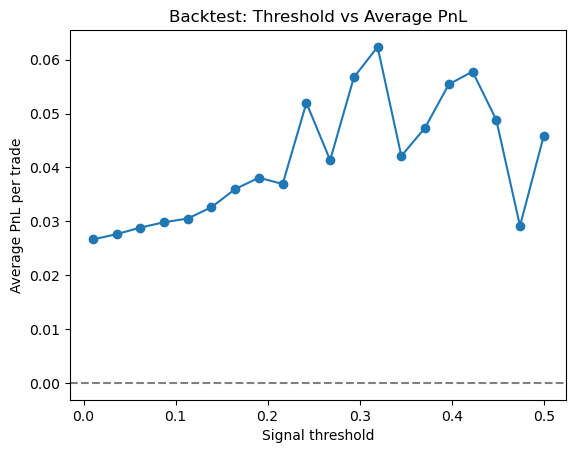

In [31]:
# Microstep: plot threshold vs average PnL
import matplotlib.pyplot as plt

df_thresh = pd.DataFrame(results)

plt.plot(df_thresh["threshold"], df_thresh["avg_pnl"], marker="o")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Signal threshold")
plt.ylabel("Average PnL per trade")
plt.title("Backtest: Threshold vs Average PnL")
plt.show()


In [32]:
# Microstep: see how many trades remain at profitable thresholds

for t in [0.07, 0.10, 0.15, 0.20, 0.30]:
    active = (crypto_df["signal_diff"].abs() > t).sum()
    print(f"Threshold {t:.2f}: {active} trades")


Threshold 0.07: 178 trades
Threshold 0.10: 174 trades
Threshold 0.15: 152 trades
Threshold 0.20: 131 trades
Threshold 0.30: 94 trades
